In [27]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as spi
import scipy.optimize as spo
import networkx as nx

In [2]:
# # Initialize matplotlib for LaTeX
# plt.rc('text', usetex=True)
# plt.rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{amssymb} \usepackage{bm}')

# Plan for simple custom Laplacian

Let's try to make a prediction of the shape of eigenvalues of a matrix formed as $a \tanh(bD) + A$ for $a, b \in \mathbb{R}$ parameters (we'll want to change these to see if our prediction tracks empirical data).

My guess is that this will behave as though $D$ is a diagonal of iid $\mathcal{N}(0, 1)$ variables and $A$ is a GOE matrix. In that case, the eigenvalue distribution should be

$$ a \tanh(b\mathcal{N}(0, 1)) \boxplus \mu_{\mathsf{SC}} $$

Here is a plan to numerically estimate this density.

## General additive free convolution with semicircle

Paralleling the covariance situation, we can write a general formula for $G_{\nu \boxplus \mu_{\mathsf{SC}}}$.
Recall that we have

$$ G_{\nu \boxplus \mu_{\mathsf{SC}}}^{-1}(z) - \frac{1}{z} = R_{\nu \boxplus \mu_{\mathsf{SC}}}(z) = R_{\nu}(z) + z = G_{\nu}^{-1}(z) - \frac{1}{z} + z $$

Rearranging this gives the implicit equation

$$ G_{\nu \boxplus \mu_{\mathsf{SC}}}(z) = G_{\nu}(z - G_{\nu \boxplus \mu_{\mathsf{SC}}}(z)) $$

and expanding the definition of $G_{\nu}$ on the right gives

$$ G_{\nu \boxplus \mu_{\mathsf{SC}}}(z) = \int \frac{1}{z - G_{\nu \boxplus \mu_{\mathsf{SC}}}(z) - t} d\nu(t) $$

exactly paralleling the covariance version below.

## Plugging in transformed Gaussian

We want to use this with $\nu = \phi(\mathcal{N}(0, 1))$ for some $\phi$ (for us $\phi(t) = a\tanh(bt)$, but other sigmoids / other functions in general also make sense). You can actually just substitute this directly into the Stieltjes transform equation without explicitly calculating the density of $\phi(\mathcal{N}(0, 1))$:


$$ G_{\nu \boxplus \mu_{\mathsf{SC}}}(z) = \int \frac{1}{z - G_{\nu \boxplus \mu_{\mathsf{SC}}}(z) - \phi(g)} \frac{1}{\sqrt{2\pi}} e^{-g^2/2} dg $$

<span style="color:red">Our situation is different than the covariance estimation one:</span> There the unknown was the measure $\nu$ on the right, while here it is $\nu \boxplus \mu_{\mathsf{SC}}$ on the left. But, I think we can follow a somewhat similar approach. Fix a grid of $z_j = x_j + i\epsilon$ close to the real axis. Call $G_j = G_{\nu \boxplus \mu_{\mathsf{SC}}}(z_j)$. These numbers satisfy the fixed-point equation

$$ G_j = \int \frac{1}{z_j - G_j - \phi(g)} \frac{1}{\sqrt{2\pi}} e^{-g^2/2} dg $$

We can (hopefully) solve this by just iterating the above map, i.e., by running a numerical integration of

$$ G_j^{(t + 1)} = \int \frac{1}{z_j - G_j^{(t)} - \phi(g)} \frac{1}{\sqrt{2\pi}} e^{-g^2/2} dg $$

until convergence (say, until $|G_j^{(t + 1)} - G_j^{(t)}|$ becomes sufficiently small). To recovery the density of $\nu \boxplus \mu_{\mathsf{SC}}$, we can use the Stieltjes inversion formula: if this density is $\rho$, then

$$ \rho(x) = \lim_{\epsilon \to 0} -\frac{1}{\pi} \mathsf{Im}(G_{\nu \boxplus \mu_{\mathsf{SC}}}(x + i\epsilon)) $$

In particular, for $\epsilon$ small enough, we should have

$$ \rho(x_j) \approx -\frac{1}{\pi} \mathsf{Im}(G_j), $$

giving us a sequence of point values of estimates of the density.

## Better sigmoid?

One small comment: another reasonable choice of nonlinearity is $\phi(t) = t / \sqrt{1 + t^2}$, a different shape of sigmoid. For this one, it seems Mathematica is able to calculate $G_{\nu}(z)$ above for any given $z$ in closed form fairly quickly (though, weirdly, not for general $z$), so you could try this if the above numerical strategy has problems.

In [10]:
def compute_free_convolution(a, b, zs_x, z_imag_part = 1e-4, tolerance = 1e-5):    
    zs = np.hstack([zs_x + z_imag_part * 1.j])
    num_zs = zs_x.shape[0]
    # recursion for G
    G = np.zeros((num_zs), dtype=np.complex128)
    while True:
        G_old = G.copy()
        for j in range(num_zs):
            real_integrand = lambda g: np.real(1/(np.sqrt(2*np.pi)) * np.exp(-g**2/2) / (zs[j] - G[j] - a*np.tanh(b*g)))
            imag_integrand = lambda g: np.imag(1/(np.sqrt(2*np.pi)) * np.exp(-g**2/2) / (zs[j] - G[j] - a*np.tanh(b*g)))
            
            real_result, real_error = spi.quad(real_integrand, -np.inf, np.inf)
            imag_result, imag_error = spi.quad(imag_integrand, -np.inf, np.inf)
            
            G[j] = real_result + 1j * imag_result
        if np.linalg.norm(G - G_old) < tolerance:
            break

    # Stieltjes inversion
    rho = -1/np.pi * np.imag(G)
    if rho[0] > tolerance or rho[-1] > tolerance:
        print(rho[0], rho[-1])
        raise Exception("Warning: zs_x does not cover the whole support. Increase the range of zs_x.")
    return rho, G

1 1
1 2
2 1
2 2


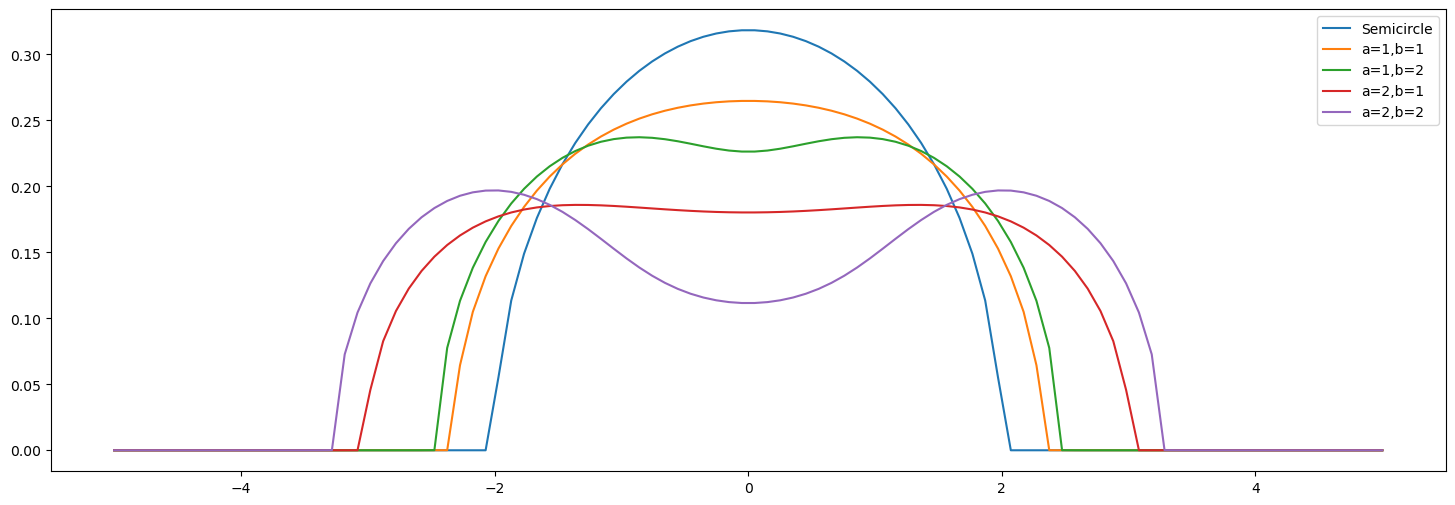

In [11]:
plt.subplots(figsize=(18, 6))
zs_x = np.linspace(-5,5,100)
rho_sc =  1/(2*np.pi) * np.sqrt(np.maximum(0, 4 - zs_x**2))
plt.plot(zs_x, rho_sc, label="Semicircle")
for a in range(1,3):
    for b in range(1,3):
        rho, _ = compute_free_convolution(a, b, zs_x, z_imag_part = 1e-4, tolerance = 1e-5)
        print(a,b)
        plt.plot(zs_x, rho, label=f"a={a},b={b}")#"$a\tanh(b\mathcal{N}(0, 1)) \boxplus \mu_{\mathsf{SC}}$")
plt.legend()

0.03292456577105113 0.03292456577105113


Exception: Warning: zs_x does not cover the whole support. Increase the range of zs_x.

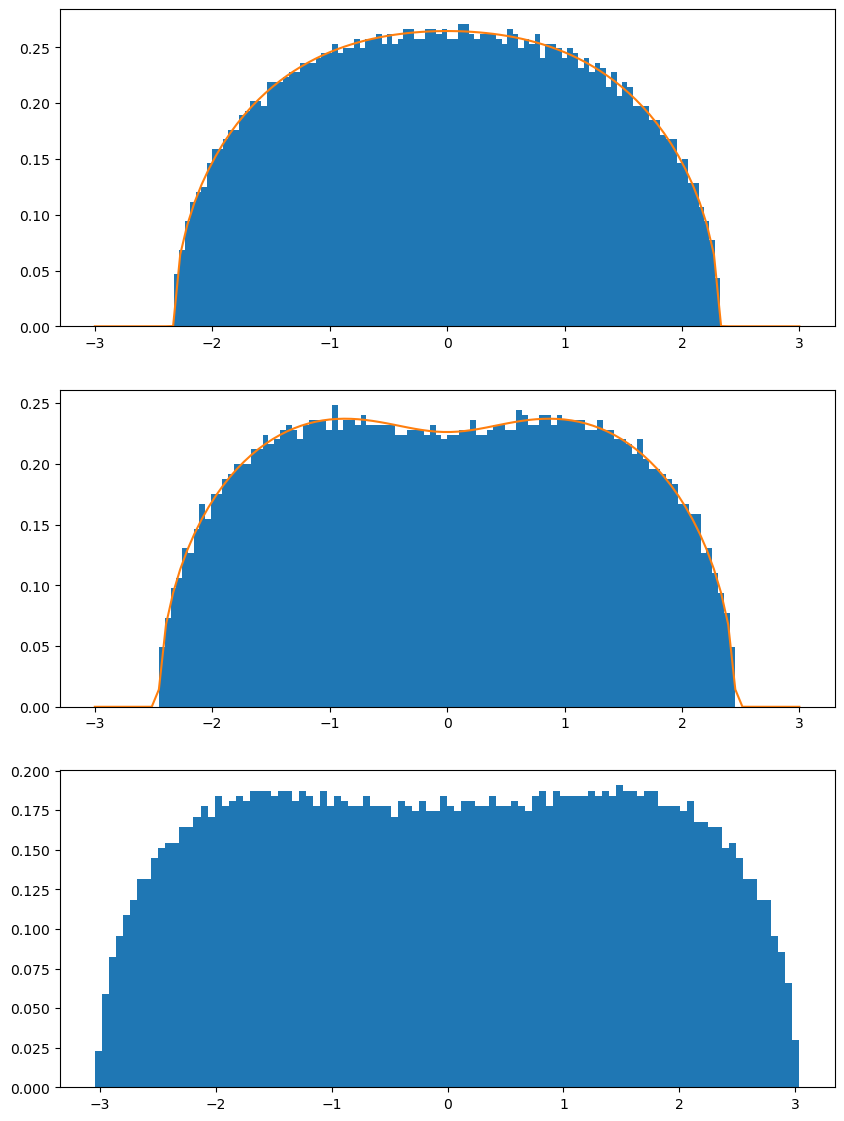

In [100]:
# compare with the empirical spectral distribution

n = 5000
G = nx.erdos_renyi_graph(n, p=.5)
A = nx.adjacency_matrix(G).toarray()
A = (A*2 - np.ones((n,n)) + np.eye(n)) / np.sqrt(n)
d = A.sum(-1).squeeze()

fig, axs = plt.subplots(3, 1, figsize=(10, 14))

x = A + np.diag(np.tanh(d))
evals = np.linalg.eigvalsh(x)
axs[0].hist(evals, bins=100, density=True)
zs_x = np.linspace(-3,3,100)
rho,_ = compute_free_convolution(1, 1, zs_x, z_imag_part = 1e-4, tolerance = 1e-5)
axs[0].plot(zs_x, rho, label=f"a=1, b=1")

x = A + np.diag(np.tanh(2*d))
evals = np.linalg.eigvalsh(x)
axs[1].hist(evals, bins=100, density=True)
zs_x = np.linspace(-3,3,100)
rho,_ = compute_free_convolution(1, 2, zs_x, z_imag_part = 1e-4, tolerance = 1e-5)
axs[1].plot(zs_x, rho, label=f"a=1, b=2")

x = A + np.diag(2*np.tanh(d))
evals = np.linalg.eigvalsh(x)
axs[2].hist(evals, bins=100, density=True)
zs_x = np.linspace(-3,3,100)
rho,_ = compute_free_convolution(2, 1, zs_x, z_imag_part = 1e-4, tolerance = 1e-5)
axs[2].plot(zs_x, rho, label=f"a=2, b=1")

axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.show()

# Planted clique distribution

In [4]:
def _plant_clique(G, k):
    n = G.number_of_nodes()
    vertices = np.random.choice(np.arange(n), k, replace=False)
    for index, u in enumerate(vertices):
        for v in vertices[index + 1 :]:
            G.add_edge(u, v)
    return G

def plot_planted_clique_spectrum(n, c):
    G = nx.erdos_renyi_graph(n, p=.5)
    A = nx.adjacency_matrix(G).toarray()
    A = (A*2 - np.ones((n,n)) + np.eye(n)) / np.sqrt(n)
    d = A.sum(-1).squeeze()

    x = A + np.diag(np.tanh(d))
    evals = np.linalg.eigvalsh(x)
    plt.hist(evals, bins=100, density=True, alpha=0.5)
    zs_x = np.linspace(-3,3,100)

    G = _plant_clique(G, int(c*np.sqrt(n)))
    A = nx.adjacency_matrix(G).toarray()
    A = (A*2 - np.ones((n,n)) + np.eye(n)) / np.sqrt(n)
    d = A.sum(-1).squeeze()
    x = A + np.diag(np.tanh(d))
    evals = np.linalg.eigvalsh(x)
    plt.hist(evals, bins=100, density=True, alpha=0.5)

    plt.show()


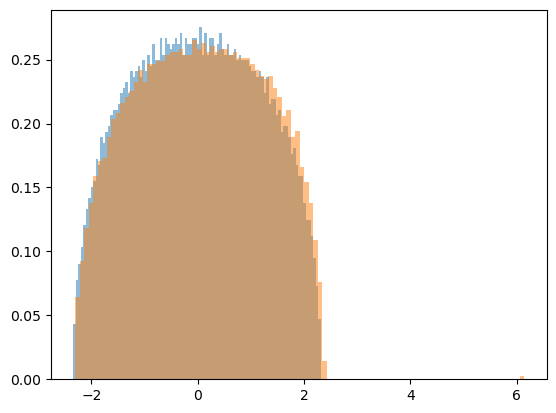

In [11]:
plot_planted_clique_spectrum(n=5000, c=5)

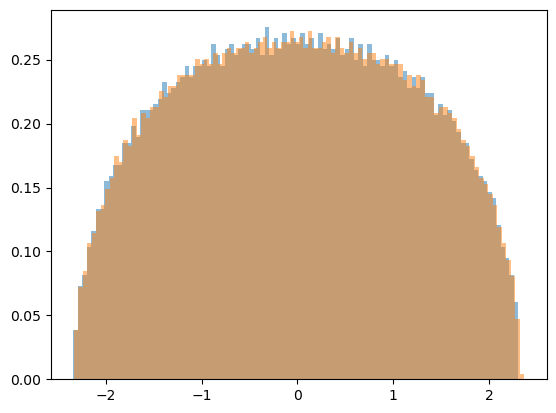

In [10]:
plot_planted_clique_spectrum(n=5000, c=1)

0.9242299261405034


(array([4.932e+03, 3.000e+00, 2.000e+00, 3.000e+00, 1.000e+00, 6.000e+00,
        1.000e+00, 4.000e+00, 4.000e+00, 2.000e+00, 4.000e+00, 2.000e+00,
        2.000e+00, 1.000e+00, 6.000e+00, 0.000e+00, 3.000e+00, 2.000e+00,
        2.000e+00, 2.000e+01]),
 array([0.        , 0.0462115 , 0.09242299, 0.13863449, 0.18484599,
        0.23105748, 0.27726898, 0.32348047, 0.36969197, 0.41590347,
        0.46211496, 0.50832646, 0.55453796, 0.60074945, 0.64696095,
        0.69317244, 0.73938394, 0.78559544, 0.83180693, 0.87801843,
        0.92422993]),
 <BarContainer object of 20 artists>)

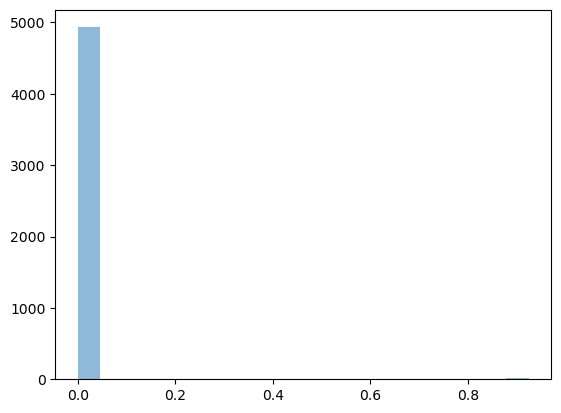

In [42]:
# visualize distribution of a * tanh(b * (g + c * indicator)) - a * tanh(b * g)
n = 5000
c = 1
g = np.random.randn(n)
indicator = np.zeros(n)
indicator[:int(c*np.sqrt(n))] = 1
np.random.shuffle(indicator)
a = 1
b = 1
x = a*np.tanh(b*(g+c*indicator)) - a*np.tanh(b*(g))
print(x.max())
plt.hist(x, bins=20, alpha=0.5) #distribution of signal

(array([353., 179., 128., 115., 105.,  84.,  74.,  75.,  66.,  65.,  69.,
         61.,  67.,  51.,  50.,  52.,  54.,  51.,  36.,  64.,  52.,  51.,
         49.,  58.,  49.,  44.,  39.,  37.,  40.,  48.,  48.,  48.,  53.,
         42.,  39.,  29.,  41.,  51.,  35.,  36.,  36.,  42.,  47.,  46.,
         31.,  45.,  48.,  41.,  44.,  41.,  44.,  29.,  30.,  27.,  41.,
         37.,  29.,  38.,  32.,  36.,  30.,  37.,  41.,  41.,  44.,  39.,
         31.,  36.,  38.,  39.,  35.,  38.,  36.,  46.,  42.,  33.,  32.,
         47.,  38.,  38.,  36.,  44.,  35.,  36.,  47.,  48.,  39.,  46.,
         48.,  40.,  43.,  44.,  37.,  42.,  36.,  44.,  38.,  37.,  30.,
         17.]),
 array([1.30944901e-09, 9.97134002e-03, 1.99426787e-02, 2.99140174e-02,
        3.98853562e-02, 4.98566949e-02, 5.98280336e-02, 6.97993723e-02,
        7.97707110e-02, 8.97420497e-02, 9.97133884e-02, 1.09684727e-01,
        1.19656066e-01, 1.29627405e-01, 1.39598743e-01, 1.49570082e-01,
        1.59541421e-01, 1.6951

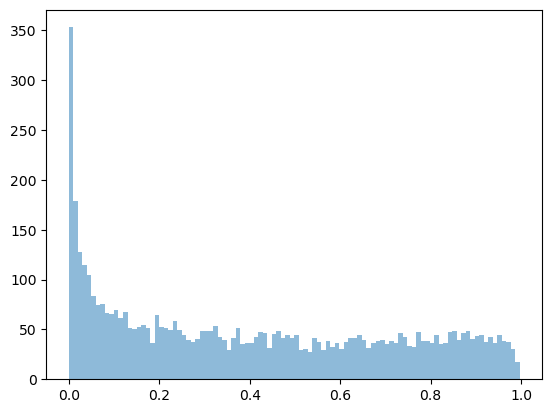

In [33]:
# visualize distribution of a\tanh(b d) for planted distribution 
n = 5000
c = 1
g = np.random.randn(n)
indicator = np.zeros(n)
indicator[:int(c*np.sqrt(n))] = 1
np.random.shuffle(indicator)
a = 1
b = 1
x = a*np.tanh(b*(g+c*indicator))
# plt.hist(x1, bins=100, density=True, alpha=0.5) #distribution of noise
plt.hist(x**2, bins=100, alpha=0.5) #distribution of signal

# Computation for BBP phase transition

In [95]:
def compute_BBP_transition(a,b,zs_x=np.linspace(-5,5,100), tolerance=1e-5, z_imag_part = 1e-4):
    rho, G = compute_free_convolution(a=a, b=b, zs_x=zs_x, z_imag_part = z_imag_part, tolerance = tolerance)
    # estimate the right edge of the null distribution's support
    diff = np.abs(np.diff(rho))
    diff_tol = np.abs(diff[-1]) * 100
    B_coordinate = np.where(diff > diff_tol)[0][-1]+1
    B = zs_x[B_coordinate]

    # plt the graph of null distribution to check the esitmation of B
    plt.plot(zs_x, rho, label=f"a={a},b={b}")
    plt.axvline(x=B, color='r', linestyle='--', label="Estimated right edge of the support")
    plt.legend()
    plt.show()

    # solve the equation to find the critical value of c where BBP transition happens
    # equation is c + c' = 1/G(B+), where c'=effective signal = E(a*tanh(b(g+c)))
    def f(c,a,b,value):
        integrand = lambda g: 1/(np.sqrt(2*np.pi)) * np.exp(-g**2/2) * a * np.tanh(b*(g+c[0]))
        result, error = spi.quad(integrand, -np.inf, np.inf)
        return np.array([c[0] + result - value])
    def fprime(c,a,b,value):
        integrand = lambda g: 1/(np.sqrt(2*np.pi)) * np.exp(-g**2/2) * a * b * (1-np.tanh(b*(g+c[0]))**2)
        result, error = spi.quad(integrand, -np.inf, np.inf)
        return np.array([1 + result])

    c_critical = spo.fsolve(func=f, x0=np.array([1]), args=(a,b,float(1/np.real(G[B_coordinate]))), fprime=fprime)

    result = f(c_critical,a,b,float(1/np.real(G[B_coordinate])))
    if np.abs(result) > tolerance:
        print("result")
        raise Exception("Failed to find the critical value of c")
    print(f"c_critical={c_critical[0]}")

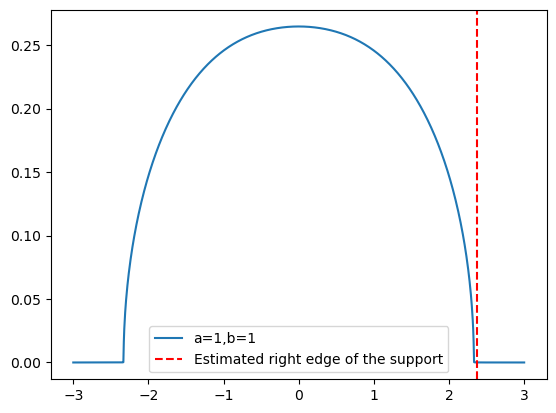

c_critical=0.8795684122894112


In [97]:
compute_BBP_transition(a=1,b=1, zs_x=np.linspace(-3,3,1000))

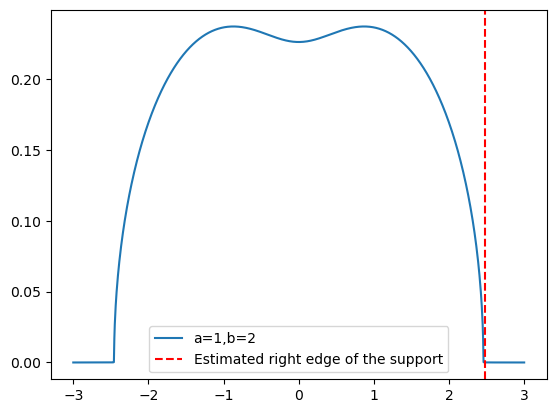

c_critical=0.8113508437929997


In [98]:
compute_BBP_transition(a=1,b=2, zs_x=np.linspace(-3,3,1000))

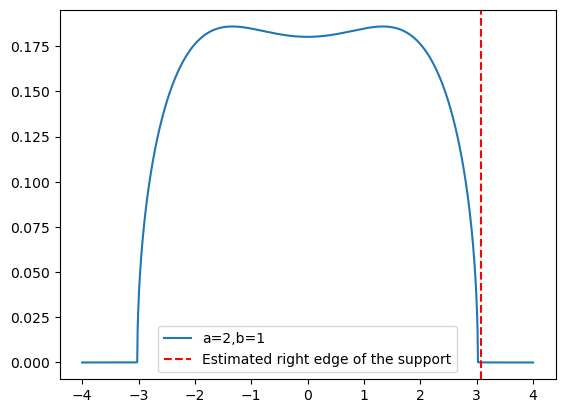

c_critical=0.7941258235135237


In [99]:
compute_BBP_transition(a=2,b=1, zs_x=np.linspace(-4,4,1000))

# <span style="color:red">Covariance estimation code</span>

<span style="color:red">NOTE: I don't think this will actually be useful, but I had already put it in here, so including just in case.</span>

This generates the example of covariance estimation figure from my lecture notes.

Recall that this is using the formula for multiplicative free convolution with Marchenko-Pastur, that for any compactly supported probability measure $\mu$,

$$ G_{\mu \boxtimes \mu_{\mathsf{MP}(c)}}(z) = \int \frac{1}{z - x(1 - c + cz G_{\mu \boxtimes \mu_{\mathsf{MP}(c)}}(z))} d\mu(x). $$

In [2]:
d = 500
m = 2500

In [3]:
# True eigenvalues: half at 1, half at 2
Sigma = np.zeros((d, d))
for i in range(d):
    if i % 2 == 0:
        Sigma[i, i] = 1
    else:
        Sigma[i, i] = 2

In [4]:
# Generate synthetic data and sample covariance    
Sigma_sqrt = np.sqrt(Sigma)
G = np.random.normal(size=(d, m))
X = Sigma_sqrt @ G
Sigma_hat = X @ X.T / m

In [10]:
# Grid sizes
num_ts = 15
num_zs = 50
z_imag_part = 1.

# Generate grids
ts = np.linspace(0.5, 3.0, num_ts)
zs_x = np.linspace(0.0, 5.0, num_zs)
zs = np.hstack([zs_x + z_imag_part * 1.j])

evals = np.linalg.eigvalsh(Sigma_hat)

# Build matrices to express the above equation between Stieltjes transforms of observation and input
G_hats = np.zeros(num_zs, dtype=np.complex256)
G_mat = np.zeros((num_zs, num_ts), dtype=np.complex256)
for b in range(num_zs):
    G_hats[b] = 1.0 / d * (1.0 / (zs[b] - evals)).sum()
    
for a in range(num_ts):
    for b in range(num_zs):
        G_mat[b, a] = 1.0 / (zs[b] - ts[a] * (1. - d/m + d/m * zs[b] * G_hats[b]))
        
# cvxpy linear program
ws = cv.Variable(num_ts)
G_err = cv.hstack([G_mat.real @ ws - G_hats.real, G_mat.imag @ ws - G_hats.imag])
# Minimize infinity norm => linear program
objective = cv.Minimize(cv.norm(G_err, p='inf'))
constraints = [ws >= 0, cv.sum(ws) == 1]
prob = cv.Problem(objective, constraints)

value = prob.solve(solver='MOSEK')
print(value)

0.0005797104157126975


In [8]:
# Truncate to only include the point masses with enough mass
ws_nonzero = ws.value[ws.value > 1e-2]
ts_nonzero = ts[ws.value > 1e-2]

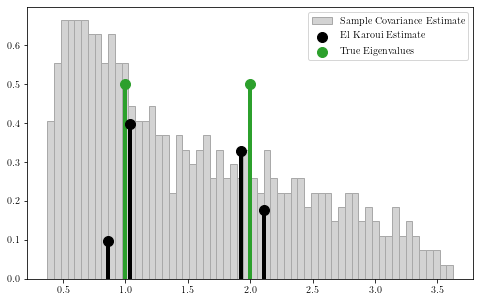

In [9]:
plt.subplots(figsize=(8, 5))

_ = plt.hist(np.linalg.eigvalsh(Sigma_hat), bins=60, density=True, label='$\\textrm{Sample Covariance Estimate}$', facecolor='lightgray', edgecolor='darkgray', linewidth=1)

plt.scatter(ts_nonzero, ws_nonzero, color='black', s=100, zorder=10, label='$\\textrm{El Karoui Estimate}$')
for i in range(ws_nonzero.shape[0]):
    plt.vlines(ts_nonzero[i], 0.0, ws_nonzero[i], linewidth=4, zorder=10)
    
ws_true = np.array([0.5, 0.5])
ts_true = np.array([1.0, 2.0])

plt.scatter(ts_true, ws_true, color=(0.172549,0.627451,0.172549), s=100, zorder=5, label='$\\textrm{True Eigenvalues}$')
for i in range(ws_nonzero.shape[0]):
    plt.vlines(ts_true, 0.0, ws_true, color=(0.172549,0.627451,0.172549), zorder=5, linewidth=4)
    
plt.legend()